In [1]:
import bmi.wrapper
import pathlib
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import matplotlib.collections
import json
import cv2

import sandbox_fm.plots
import sandbox_fm.depth
import sandbox_fm.sandbox_fm
import sandbox_fm.calibrate
%matplotlib inline

No kinect found, using test images


Error: Can't open device. 1.) is it plugged in? 2.) Read the README


In [2]:
# load calibration information (projection and roi)
with open('../calibration.json') as f:
    calibration = json.load(f)

In [3]:
# initialize the model
model = bmi.wrapper.BMIWrapper('dflowfm')
path = pathlib.Path('../tests/FM_zandbak_update_PV_v1/zm_v2.mdu')
# make sure to pass absolute path
model.initialize(str(path.absolute()))

In [4]:
# read data from the model
data = {}
sandbox_fm.sandbox_fm.update_delft3d_initial_vars(data, model)

# check which points are in the sandbox
model_bbox = matplotlib.path.Path(calibration['model_points'])
data['node_in_box'] = model_bbox.contains_points(np.c_[data['xk'], data['yk']])
data['cell_in_box'] = model_bbox.contains_points(np.c_[data['xzw'], data['yzw']])


In [5]:
# run some timesteps
for i in range(100):
    model.update()
# get the time varying variables
sandbox_fm.sandbox_fm.update_delft3d_vars(data, model)
unorm0 = np.sqrt(data['ucx']**2 + data['ucy']**2)

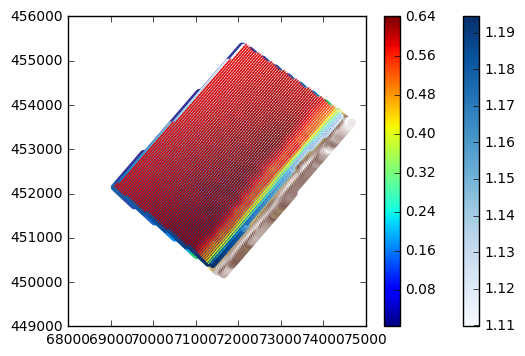

In [6]:
# plot them
idx = data['node_in_box']
plt.scatter(
    data['xk'][idx], 
    data['yk'][idx], 
    c=data['zk'][idx], 
    edgecolor='none',
    cmap='terrain',
    s=40
)
idx = np.logical_and(data['cell_in_box'], data['is_wet'])
plt.scatter(
    data['xzw'][idx], 
    data['yzw'][idx], 
    c=data['s1'][idx], 
    edgecolor='none',
    cmap='Blues'    
)
plt.colorbar()

plt.quiver(
    data['xzw'][idx], data['yzw'][idx], 
    data['ucx'][idx], data['ucy'][idx],
    unorm0[idx],
    units='xy',
    scale=0.005
)
plt.colorbar()

In [8]:
# define an intervention
square = matplotlib.path.Path([
        [71000, 451000],
        [71100, 451000],
        [71100, 451100],
        [71000, 451100]
    ])
square_idx = square.contains_points(np.c_[data['xk'], data['yk']])
zk = model.get_var('zk')
zk[square_idx] = 10.0
model.set_var_slice('zk', [0], [len(zk)], zk)




In [9]:
for i in range(100):
    model.update(60)
sandbox_fm.sandbox_fm.update_delft3d_vars(data, model)


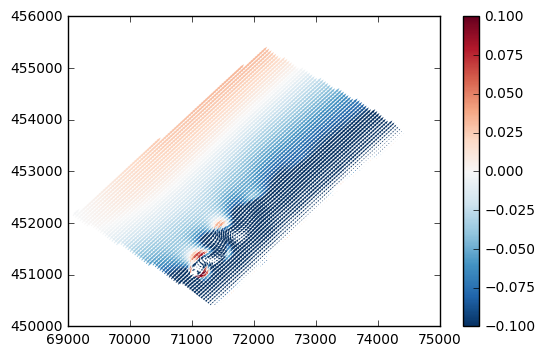

In [10]:
# I expected this to result in a change in the flow field. 
unorm = np.sqrt(data['ucx']**2 + data['ucy']**2)
idx = np.logical_and(data['cell_in_box'], data['is_wet'])
plt.quiver(
    data['xzw'][idx], data['yzw'][idx], 
    data['ucx'][idx], data['ucy'][idx],
    (unorm - unorm0)[idx],
    units='xy',
    scale=0.005,
    cmap=matplotlib.cm.RdBu_r,
    clim=(-0.1, 0.1)
)
plt.colorbar()

In [11]:
# now change bl
xzw = model.get_var('xzw')
yzw = model.get_var('yzw')
bl = model.get_var('bl')
square_idx = np.where(square.contains_points(np.c_[xzw, yzw]))
bl[square_idx] = 10.0
model.set_var('bl', bl)


In [12]:
for i in range(10):
    model.update(60)
sandbox_fm.sandbox_fm.update_delft3d_vars(data, model)


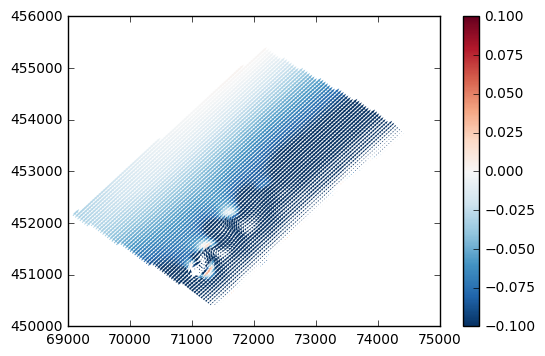

In [13]:
# I expected this to result in a change in the flow field. 
unorm = np.sqrt(data['ucx']**2 + data['ucy']**2)
idx = np.logical_and(data['cell_in_box'], data['is_wet'])
plt.quiver(
    data['xzw'][idx], data['yzw'][idx], 
    data['ucx'][idx], data['ucy'][idx],
    (unorm - unorm0)[idx],
    units='xy',
    scale=0.005,
    cmap=matplotlib.cm.RdBu_r,
    clim=(-0.1, 0.1)
)
plt.colorbar()

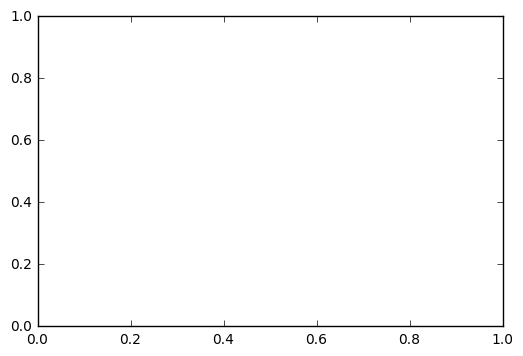

In [17]:
fig, ax = plt.subplots()
ax.redraw_in_frame?